In [2]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle
from IPython.core.display import display, HTML, Markdown
from sklearn.svm import SVC
from mvpa2.measures.base import CrossValidation
from mvpa2.clfs.meta import NFoldPartitioner
from mvpa2.clfs.svm import LinearCSVMC
from mvpa2.datasets.mri import fmri_dataset
import mvpa2
from visualization import visualize_corr

from sklearn.calibration import CalibratedClassifierCV
from nilearn.masking import unmask
from mvpa_sst_utils import *

import sys
import os

sys.path.append(os.path.abspath("../../ml/"))

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import LeaveOneGroupOut

import math

from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

/tmp/ipykernel_2906/801465192.py:8: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown
Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):
/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/visualization.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14,

In [3]:
from mvpa2.mappers.flatten import mask_mapper
import nibabel as nib

In [4]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

We use scikit-learn, implementing a forced-choice scorer. The aim of this notebook is to focus laser-sharp on outputting the content we want for the poster. We avoid content that isn't focused on this.

In [ ]:
from nilearn.image import threshold_img
#mvpa_Dataset_posterror_conditions_84subs_post_stop_cg
def create_set_of_coef_maps(classifier, mask_value,output_filename):
    coefs_for_mask_0 = get_LinearSVC_coefs(
    classifier,
    mask_value,
    smoothing=None)
    coefs_for_mask_0.to_filename(
        ml_data_folderpath + 
        "/SST/" + output_filename + "_nsm.nii.gz")
    
    thresh = np.min([-np.min(coefs_for_mask_0.get_fdata()),np.max(coefs_for_mask_0.get_fdata())])/4
    threshold_img(coefs_for_mask_0,thresh,two_sided=True).to_filename(
        ml_data_folderpath + 
        "/SST/" + output_filename + "_nsm_thresh.nii.gz")


    try:
        for sm_level in [2, 5]:
            coefs_for_mask = get_LinearSVC_coefs(
                classifier,
                mask_value,
                smoothing=sm_level)
            coefs_for_mask.to_filename(
                ml_data_folderpath + 
                "/SST/" + output_filename + "_sm" + str(sm_level) + ".nii.gz")
            
            if sm_level==2:
                thresh = np.min([-np.min(coefs_for_mask_0.get_fdata()),np.max(coefs_for_mask_0.get_fdata())])/2
                threshold_img(coefs_for_mask,thresh,two_sided=True).to_filename(
                    ml_data_folderpath + 
                    "/SST/" + output_filename + "_sm" + str(sm_level) + "_thresh0_5.nii.gz")

    except ValueError:
            print("couldn't do one or more smoothed masks because it resulted in an empty mask.")
    
    return(coefs_for_mask_0)


## Load

In [5]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [6]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [7]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [8]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [9]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt_2022_02_26.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

## new code

## whole brain

Now let's scale that up to the full dataset.

In [10]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

## masks

We get the same file this time, but we apply a mask before doing learning.

In [10]:
from generic_utils import *

In [11]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [12]:
for mask_name in all_masks['mask_name']:
#    mask_value = all_masks[mask_name]
    print(mask_name,end=", ")

planning_association-test_z_FDR_0.01, executive function_association-test_z_FDR_0.01, response inhibition_association-test_z_FDR_0.01, inhibition_association-test_z_FDR_0.01, error_association-test_z_FDR_0.01, harvardoxford-cortical_prob_Frontal Orbital Cortex, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars opercularis, harvardoxford-cortical_prob_Inferior Frontal Gyrus, pars triangularis, 

### try out one mask

In [13]:
brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl"

#brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Insular Cortex.pkl"
#brain_data_filepath = '/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_response inhibition_association-test_z_FDR_0.01.pkl'

yikes, that does seem a bit too good. Particularly considering that the non-forced-choice rsults are also up really high. We shouldn't be seeing resutls this high! Let's see how it goes across all the masks I have chosen.

In [14]:
from visualization import *

harvardoxford-cortical_prob_Frontal Orbital Cortex
3024.91975308642


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


.................................................................................
0.5987654320987654 0.9506172839506173
['CorrectGo' 'CorrectStop']


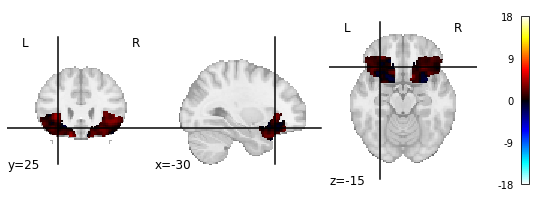

In [39]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        ml_data_folderpath + "/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs, get_predict_and_prob = do_LinearSVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        
        create_set_of_coef_maps(
            forced_choice_results['classifier'], 
            Brain_Data_allsubs.a['mask_nifti'].value,
            "mvpa_Dataset_conditions_84subs_correct_cond_" + mask_name)
        
        print(forced_choice_results['classifier'].classes_)
        
        break

In [17]:
from nilearn.image import threshold_img

Do we do an analysis with just the PFC and call it a day?

### Re-implementing v3

This is a useful sanity check, becuase it's helpufl to try and explain why we're doing so much  better than rpeviously.

In [ ]:

def do_LinearSVC(train_X,train_y,test_X,test_y):
    sklearn_clf = LinearSVC(penalty='l2', max_iter=1e4)
    #same as v3, my nilearn learner integrated with nltools
    #https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html
    
    #sklearn_clf = CalibratedClassifierCV(clf_svc)
    #train
    sklearn_clf.fit(train_X, train_y)

    #get the _probability_ we fall into each class
    #we'll use similarity/correlation here.
    predict_y_prob = pearson_img_series(test_X,sklearn_clf.coef_)#sklearn_clf.predict_proba(test_X)
    predict_y = sklearn_clf.predict(test_X)
    return(predict_y,predict_y_prob,sklearn_clf)


In [ ]:
linear_results_with_similarity = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)

In [ ]:
forced_choice_results = linear_results_with_similarity

In [ ]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

Possibly old dataset:

In [ ]:
(prediction, forced_choice_prediction)

Current dataset:

In [ ]:
(prediction, forced_choice_prediction)

In [ ]:
linear_results_with_similarity = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)
forced_choice_results = linear_results_with_similarity
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
(prediction, forced_choice_prediction)

Formerly this was .85, .95, which was remarkable--we've now pretty clearly reproduced the result we were getting using nltools..

However, after I updated it based on documentation here (https://nilearn.github.io/modules/generated/nilearn.decoding.Decoder.html) it performed less well. Not sure why the classifier is performing _less_ well in this setup than the former one - perhaps hte sort of normalization that I am doing on each side.

On reflection, I don't really want to present the forced choice data, except as an auxillary. I'm not sure what it's saying because it is quite erratic!

In [ ]:
sample_wise_results = forced_choice_results['sample_wise']
cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']

individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)
full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')


In [ ]:
from outlier_detection import *



#### v3 mask

In [ ]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)

        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

## Apply the main analysis, looping through masks

In [38]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results

create_set_of_coef_maps(
    forced_choice_results['classifier'], 
    Brain_Data_allsubs.a['mask_nifti'].value,
    "mvpa_Dataset_conditions_84subs_correct_cond")

whole brain
124486.5
.

KeyboardInterrupt: 

In [ ]:
forced_choice_results['classifier'].classes_

In [ ]:
print("whole brain, using obsolete incorrect timing file")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/archive/mvpa_Dataset_conditions_84subs_correct_cond.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectGo']=inv_log_transform(sample_wise_results['pred_prob_CorrectGo'])
forced_choice_results['sample_wise']['ln_inv_pred_prob_CorrectStop']=inv_log_transform(sample_wise_results['pred_prob_CorrectStop'])



print(prediction,forced_choice_prediction)

forced_choice_results_dict[mask_name]=forced_choice_results
# print_forced_choice_results(
#     forced_choice_results,
#     individual_differences,
#     ['ln_inv_pred_prob_CorrectStop'])

## Contrast between CorrectStop and CorrectGo...

# v5 on PES

Here we're going to run the same "version 5" analysis as above, but on the PES contrast instead. Should be straightforward to replicate.


In [19]:
pes_vars_of_interest  =['RTFS_factor_1','RTFS_factor_2','RTFS_f1_minus_f2', 'SST_PostErrorSlowW1_median','SST_PostErrorSlowW1_mean','SST_pes_mean_limited','FFQ_v2_Mean_Weighted_Nutrient_Density']


## discriminability

In [20]:
from generic_utils import *
## additional masks

all_masks = get_failure_masks(ml_data_folderpath)

### masked, conditions separate

In [21]:
all_masks

,mask_name,mask_filepath,thresh
0,negative affect_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
1,emotion regulation_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
2,harvardoxford-cortical_prob_Frontal Medial Cortex,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
3,negative emotions_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
4,self referential_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
5,harvardoxford-cortical_prob_Frontal Orbital Co...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
6,"harvardoxford-cortical_prob_Cingulate Gyrus, a...",/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0


/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_negative affect_association-test_z_FDR_0.01.pkl
negative affect_association-test_z_FDR_0.01
1170.0925925925926


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


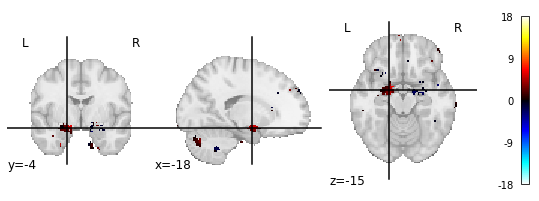

.................................................................................0.5185185185185185 0.6172839506172839


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.9346730142360928. But, you have given threshold=0.99 
  warnings.warn("The given float value must not exceed {0}. "


couldn't do one or more smoothed masks because it resulted in an empty mask.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_emotion regulation_association-test_z_FDR_0.01.pkl
emotion regulation_association-test_z_FDR_0.01
913.3456790123457


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


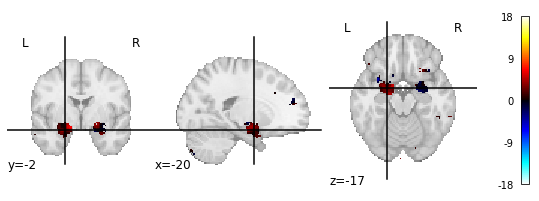

.................................................................................0.6172839506172839 0.8148148148148148
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Frontal Medial Cortex.pkl
harvardoxford-cortical_prob_Frontal Medial Cortex
1567.4753086419753


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


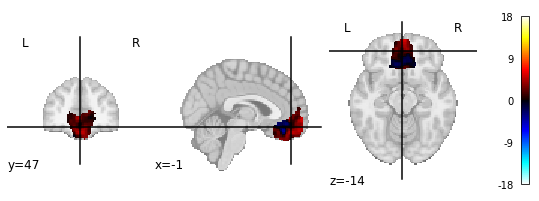

.................................................................................0.5123456790123457 0.5802469135802469
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_negative emotions_association-test_z_FDR_0.01.pkl
negative emotions_association-test_z_FDR_0.01
558.4444444444445


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


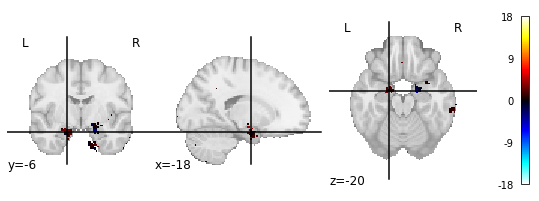

.................................................................................0.5061728395061729 0.49382716049382713


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.7904260748655295. But, you have given threshold=0.99 
  warnings.warn("The given float value must not exceed {0}. "


couldn't do one or more smoothed masks because it resulted in an empty mask.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_self referential_association-test_z_FDR_0.01.pkl
self referential_association-test_z_FDR_0.01
1530.5


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


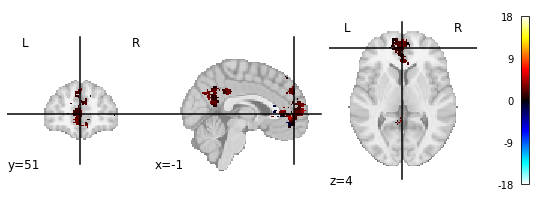

.................................................................................0.5493827160493827 0.5802469135802469


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/_utils/param_validation.py:72: UserWarning: The given float value must not exceed 0.9659322909784599. But, you have given threshold=0.99 
  warnings.warn("The given float value must not exceed {0}. "


couldn't do one or more smoothed masks because it resulted in an empty mask.
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl
harvardoxford-cortical_prob_Frontal Orbital Cortex
2828.4876543209875


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


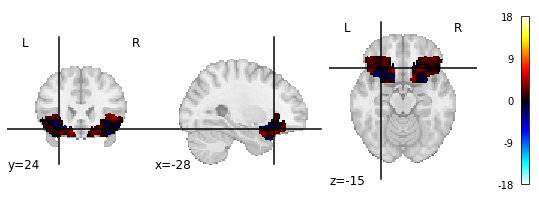

.................................................................................0.6172839506172839 0.7530864197530864
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_harvardoxford-cortical_prob_Cingulate Gyrus, anterior division.pkl
harvardoxford-cortical_prob_Cingulate Gyrus, anterior division
2681.061728395062


/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


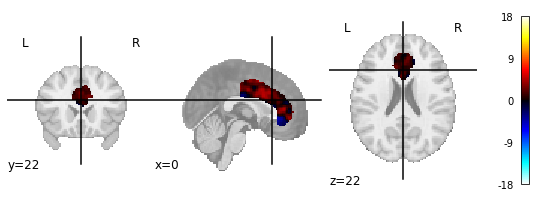

.................................................................................0.5679012345679012 0.691358024691358


In [22]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_" +
        mask_name
        + ".pkl"
    )
    print(brain_data_filepath)
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))
        
        masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
        plotting.plot_stat_map(masked_preview,vmax=18)
        plotting.show()
        forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)
        
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterCS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingCorrectStop'])
        forced_choice_results['sample_wise']['ln_inv_pred_prob_CGAfterFS']=inv_log_transform(forced_choice_results['sample_wise']['pred_prob_CorrectGoFollowingFailedStop'])

        print(prediction,forced_choice_prediction)
        
        create_set_of_coef_maps(
            forced_choice_results['classifier'], 
            Brain_Data_allsubs.a['mask_nifti'].value,
            "mvpa_Dataset_posterror_conditions_84subs_post_stop_cg_" + mask_name)
#         forced_choice_results_dict[mask_name]=forced_choice_results

        
#         print_forced_choice_results(
#             forced_choice_results,
#             individual_differences,
#             ['ln_inv_pred_prob_CGAfterCS'],
#             behavioral_measures = pes_vars_of_interest,
#             target_y='CorrectGoFollowingCorrectStop')
#         print_forced_choice_results(
#             forced_choice_results,
#             individual_differences,
#             ['ln_inv_pred_prob_CGAfterFS'],
#             behavioral_measures = pes_vars_of_interest,
#             target_y='CorrectGoFollowingFailedStop')

### whole brain, conditions separate

In [37]:
print("whole brain")
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_posterror_conditions_84subs_post_stop_cg.pkl"
)

with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

print(sum(sum(Brain_Data_allsubs.samples>0))/len(Brain_Data_allsubs.samples))

#masked_preview = unmask(Brain_Data_allsubs.samples[0], Brain_Data_allsubs.a['mask_nifti'].value)
#plotting.plot_stat_map(masked_preview,vmax=18)

forced_choice_results = do_forced_choice(Brain_Data_allsubs,get_predict_and_prob=do_LinearSVC)


sample_wise_results = forced_choice_results['sample_wise']
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])


print(prediction,forced_choice_prediction)

create_set_of_coef_maps(
    forced_choice_results['classifier'], 
    Brain_Data_allsubs.a['mask_nifti'].value,
    "mvpa_Dataset_posterror_conditions_84subs_post_stop_cg")

whole brain
122853.14814814815
.

KeyboardInterrupt: 

In [30]:
forced_choice_results['classifier'].classes_

array(['CorrectGoFollowingCorrectStop', 'CorrectGoFollowingFailedStop'],
      dtype='<U29')

In [35]:
print(forced_choice_results['classifier'].class_weight)

None


In [36]:
print(forced_choice_results['classifier'].score)

<bound method ClassifierMixin.score of LinearSVC(max_iter=10000.0)>


So, we probably cannot do the PES. The forced choice analysis is _worse_ than chance; the non-forced choice analysis is barely over chance. If we had time to find another approach, we could publish it, but we've already put quite a bit of time into that, and so I don't think we'll find something before the deadline.

the mae is diverging in a way which suggests there is mae correlation with the variable itself, which isn't very meaningful.